In [1]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import datetime
import time
from sklearn import metrics
from collections import defaultdict
import torch
import torch.nn as nn
from torch import nn, Tensor
from typing import List
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# read data
pairs = 1000
pairdata, freqpairs, n_size, n_interval = get_univ_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)

In [3]:
seq_set = defaultdict(list)
target_set = defaultdict(list)
size_set = {}
seq_len = 16

for pair in range(pairs):
    size_index = pairdata[freqpairs[pair]].size_index.values
    target_index = np.concatenate((size_index[1:], size_index[0:1]))
    for i in range(len(size_index) - seq_len):
        seq_set[pair].append(size_index[i:i+seq_len])
        target_set[pair].append(target_index[i:i+seq_len])
        size_set[pair] = sizedata[pair]
    seq_set[pair] = np.array(seq_set[pair])
    target_set[pair] = np.array(target_set[pair])

In [4]:
def sample_dataset(seed):
    np.random.seed(seed)
    dataset = []
    for pair in range(pairs):
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size_set[pair], target_set[pair][ran_index]])
    return dataset

def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

dataset = sample_dataset(0)
dataloader = DataLoader(dataset[:32], batch_size=32, shuffle=False)

In [5]:
class SizeToHidden(nn.Module):
    def __init__(self, input_size, hidden_dims, hidden_size, n_layer):
        super(SizeToHidden, self).__init__()
        self.lins = nn.ModuleList()
        self.n_layer = n_layer
        self.hidden_size = hidden_size
        in_dim = input_size 
        for h_dim in hidden_dims:
            self.lins.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(in_dim, out_features=hidden_size * n_layer)

    def forward(self, x: Tensor) -> List[Tensor]:
        for lin in self.lins:
            x = lin(x)
        x = self.output(x)
        x = x.view(-1, self.n_layer, self.hidden_size)
        x = x.permute(1, 0, 2).contiguous()
        return x

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, n_layer)
        self.h2o = nn.Linear(hidden_size, n_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.h2o(out)
        out = self.softmax(out)
        return out, hidden

In [21]:
hidden_size = 512
gru = GRU(n_size, hidden_size, 1).to(device)
s2h = SizeToHidden(n_size, [128, 256], hidden_size, 1).to(device)

In [22]:
# hidden_size = 128
# gru = GRU(n_size, hidden_size, 1).to(device)
# s2h = SizeToHidden(n_size, [64, 128], hidden_size, 1).to(device)

In [23]:
# get total parameters and trainable parameters of gru and s2h
def get_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
get_params(gru)[0], get_params(s2h)[0], get_params(gru)[0] + get_params(s2h)[0]

(850974, 168576, 1019550)

In [24]:
sum_flow = 0
for i in range(pairs):
    sum_flow += len(pairdata[freqpairs[i]])
sum_flow

287915

In [25]:
(get_params(gru)[0] + get_params(s2h)[0]) / 900000

1.1328333333333334

In [12]:
date = 'final'
gru = torch.load('model/{date}/gru.pth'.format(date=date))
s2h = torch.load('model/{date}/s2h.pth'.format(date=date))

In [11]:
date = 'univ-gru-2023-6-16-23'
gru = torch.load('model/{date}/gru-82000.pth'.format(date=date))
s2h = torch.load('model/{date}/s2h-82000.pth'.format(date=date))

In [26]:
def train(dataloader, optimizer):
    gru.train()
    s2h.train()
    sum_loss = 0
    for seq_tensor, size_tensor, target_tensor in dataloader:
        seq_tensor = inputTensor(seq_tensor).float().to(device)
        size_tensor = size_tensor.float().to(device)
        target_tensor = target_tensor.T.long().to(device)
        optimizer.zero_grad()
        output, hn = gru(seq_tensor, s2h(size_tensor))
        loss = 0
        for i in range(seq_len):
            loss += nn.NLLLoss()(output[i], target_tensor[i])
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() / seq_tensor.shape[0] * seq_tensor.shape[1]
    return sum_loss / len(dataloader.dataset)

In [27]:
lr = 5e-4
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    dataloader = DataLoader(dataset[:], batch_size=32, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.18:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 1.1431372413635255 1.252688091688156 65.24280214309692
200 1.0555506892204285 1.0921805940747265 87.09444880485535
300 0.8974429693222046 0.9673109279930594 108.79452228546143
400 0.7563305950164795 0.8128794981002813 130.8422703742981
500 0.6449965357780456 0.6928357618856427 152.5825936794281
600 0.5821445190906525 0.609105665962696 174.61198806762695
700 0.5216402912139892 0.5498686409580708 196.49943137168884
800 0.4838373601436615 0.5103911142611506 218.32937812805176
900 0.46133118677139284 0.4796472595453263 240.38262128829956
1000 0.45329303002357485 0.4573195524013042 262.46113991737366
1100 0.4269393434524536 0.436082969623208 284.77413988113403
1200 0.4199768915176392 0.4225805996549127 306.6488001346588
1300 0.4142135136127472 0.4090016643512248 328.946816444397
1400 0.3912705669403076 0.39780481805920587 350.76292181015015
1500 0.3783772361278534 0.3875572937786579 372.14080595970154
1600 0.37519757509231566 0.37883318101286906 394.1656913757324
1700 0.3667252151966095

In [ ]:
softmax = nn.Softmax(dim=2).to(device)
def sample(size_data, seq_length, start_size=8):
    gru.eval()
    s2h.eval()
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        output_seq = [start_size]
        size = start_size
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([[size]])).to(device)
            input = input.float()
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = np.random.choice(n_size, p=p_size)
            output_seq.append(size)
        return output_seq

def is_subarray(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    for i in range(len(arr1) - len(arr2) + 1):
        if np.array_equal(arr1[i:i+len(arr2)], arr2):
            return True
    return False

NameError: name 'nn' is not defined

In [15]:
# pair = 0
# start_size = 8
# for i in range(100):
#     size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))
#     a = sample(sizedata[pair], 16, start_size)
#     print(a, is_subarray(size_index, a))

In [16]:
from scipy.stats import entropy
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

s2s_pair, size_trans = get_trans(pairdata, freqpairs, 'size_index', n_size)

In [17]:
from tqdm import tqdm
encore_seq = np.zeros((pairs, 1000))
he_seq = np.zeros((pairs, 1000))

for pair in tqdm(range(1000)):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    size_seq = []
    while len(size_seq) < 1000:
        size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq.append(size)
    size_seq = np.array(size_seq)[0:1000]
    he_seq[pair] = size_seq

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq = [start_size]
        while len(size_seq) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq += list(new_size[:])
                # start_size = new_size[-1]
                # if seed > 10:
                start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        
        size_seq = np.array(size_seq)
        values, counts = np.unique(size_seq, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq[:-1] * n_size + size_seq[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        if JSD(new_size, sizedata[pair]) < 0.05:
            break
        print(pair, seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
    encore_seq[pair] = size_seq[0:1000]

100%|██████████| 1000/1000 [04:08<00:00,  4.02it/s]


In [18]:
grams = {}
for i in [2, 3, 4]:
    grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = pairdata[freqpairs[pair]]['size_index'].values
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        grams[i][pair][values] = counts
    grams[i] /= grams[i].sum(axis=1).reshape(-1, 1)

he_grams = {}
for i in [2, 3, 4]:
    he_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = he_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        he_grams[i][pair][values] = counts
    he_grams[i] /= he_grams[i].sum(axis=1).reshape(-1, 1)

encore_grams = {}
for i in [2, 3, 4]:
    encore_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = encore_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        encore_grams[i][pair][values] = counts
    encore_grams[i] /= encore_grams[i].sum(axis=1).reshape(-1, 1)

100%|██████████| 1000/1000 [00:00<00:00, 12531.01it/s]


In [19]:
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

In [20]:
he_jsds, encore_jsds = {}, {}
for i in range(2, 5):
    he_jsds[i] = []    
    encore_jsds[i] = []    
    for pair in range(pairs):
        he_jsds[i].append(JSD(grams[i][pair], he_grams[i][pair]))
        encore_jsds[i].append(JSD(grams[i][pair], encore_grams[i][pair]))
    he_jsds[i] = np.array(he_jsds[i])
    encore_jsds[i] = np.array(encore_jsds[i])

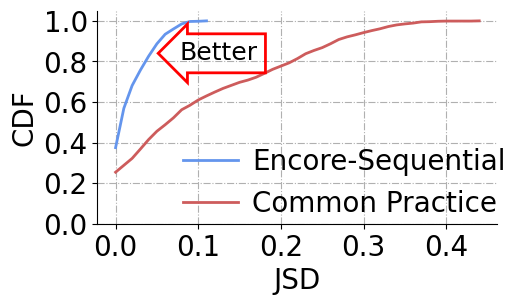

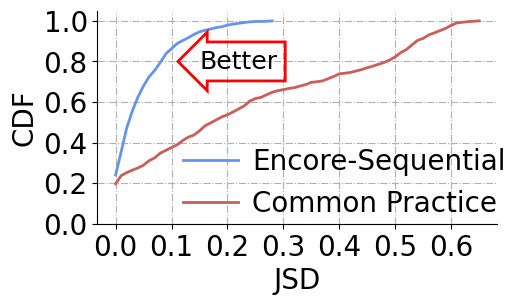

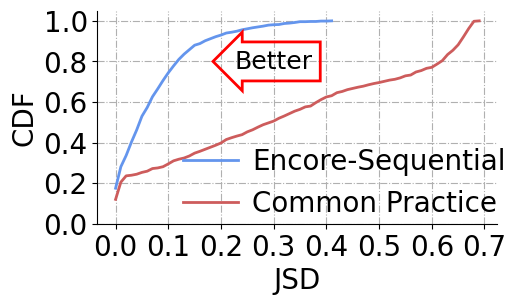

In [21]:
import matplotlib.pyplot as plt

for i in range(2, 5):
    plt.figure(figsize=(5, 3))
    plt.subplots_adjust(left=0.18, top=0.95, bottom=0.24, right=0.98)
    ax = plt.subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    values, bins = np.histogram(encore_jsds[i], bins=np.arange(0, np.max(encore_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='CornFlowerBlue', label='Encore-Sequential')
    values, bins = np.histogram(he_jsds[i], bins=np.arange(0, np.max(he_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='IndianRed', label='Common Practice')
    plt.ylim(0, 1.05)
    # plt.legend(fontsize=20, frameon=False, loc=(0.45, 0.2))
    plt.ylabel('CDF', fontsize=20)
    plt.xlabel('JSD', fontsize=20)
    plt.grid(linestyle='-.')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if i == 2:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.125, 0.84, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    elif i == 3:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.22, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    else:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.3, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    plt.legend(fontsize=20, frameon=False, loc=(0.185, -0.025), handletextpad=0.5)

    plt.savefig('figure/{i}-gram-jsd.pdf'.format(i=i), dpi=300)

In [1]:
rnn_jsds, he_jsds = [], []
for pair in range(1000):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = [start_size]
        while len(size_seq_gen) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq_gen += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = np.array(size_seq_gen)
        values, counts = np.unique(size_seq_gen, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        # print(seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
        if JSD(new_size, sizedata[pair]) < 0.05:
            break

    rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
    values, counts = np.unique(rnn_s2s_pair, return_counts=True)
    rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
    rnn_s2s_pair[values] = counts
    rnn_s2s_pair /= rnn_s2s_pair.sum()

    he_size_seq = []
    while len(he_size_seq) < 1000:
        size = np.random.choice(np.arange(30), p=sizedata[pair])
        he_size_seq.append(size)
    he_size_seq = np.array(he_size_seq)

    he_s2s_pair = [he_size_seq[:-1] * n_size + he_size_seq[1:]]  
    values, counts = np.unique(he_s2s_pair, return_counts=True)
    he_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    he_s2s_pair[values] = counts
    he_s2s_pair /= he_s2s_pair.sum()

    print(pair, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]), JSD(he_s2s_pair, s2s_pair[pair]))
    rnn_jsds.append(JSD(rnn_s2s_pair, s2s_pair[pair]))
    he_jsds.append(JSD(he_s2s_pair, s2s_pair[pair]))

NameError: name 'sizedata' is not defined

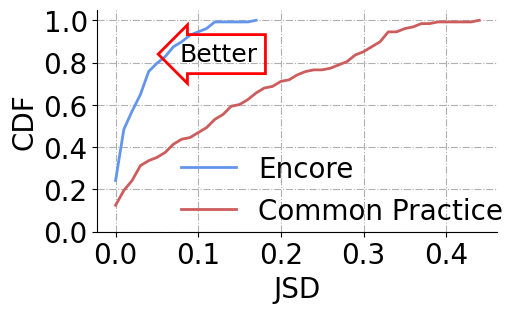

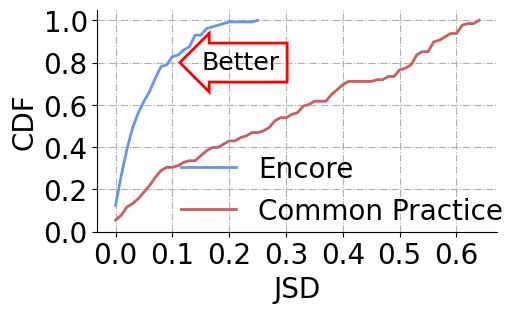

In [41]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.016796066997483282 0.07346432855368562
90 0.07909204873483928 0.2751986895385197
95 0.09532450370252392 0.31491465589104833
99 0.1320168295307611 0.3700949495105308


In [136]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.012160265192768834 0.07145898533012404
90 0.047915725836543216 0.2727736298325866
95 0.053717750535610495 0.3153216864822403
99 0.06597230544940674 0.36794891171362076


In [10]:
# torch.save(gru, 'models/gru-0504.pth')
# torch.save(s2h, 'models/s2h-0504.pth')

In [11]:
class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result
    
decoder = torch.load('models/size-decoder-0425.pth')
gru = torch.load('models/gru-0504.pth')
s2h = torch.load('models/s2h-0504.pth')

In [50]:
from scipy.stats import entropy
from tqdm import tqdm
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def sample_noisy_dataset(n, seed):
    torch.manual_seed(seed)
    dataset = []
    for i in tqdm(range(n)):
        latent_dim = 32
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()

        dis = []
        for j in range(1000):
            loss = JSD(size, sizedata[j])
            dis.append(loss)

        pair = np.argmin(dis)
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size, target_set[pair][ran_index]])
        
    return dataset

In [71]:
a = []
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)

    pair = np.argmin(dis)
    a.append(pair)

100%|██████████| 5000/5000 [05:13<00:00, 15.93it/s]


In [47]:
lr = 1e-3
# optimizer = torch.optim.Adam([{'params': s2h.parameters()}], lr=lr)
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    ran_index = np.random.permutation(len(tune_dataset))[0:1000]
    # dataset.extend([tune_dataset[i] for i in ran_index])
    dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.1:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 0.37469881772994995 0.36950908958911893 11.19027829170227
200 0.36915746331214905 0.35975850641727447 21.188878059387207
300 0.35969191789627075 0.35673402369022367 32.09577918052673


KeyboardInterrupt: 

In [74]:
from tqdm import tqdm
a = set()
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)
        # if loss < 0.02:
        #     a.add(j)

    pair = np.argmin(dis)
    a.add(pair)

100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


In [73]:
jsds = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        jsds[i][j] = JSD(sizedata[i], sizedata[j])

In [75]:
np.sort(jsds[8])

array([0.        , 0.0712686 , 0.0989841 , 0.10461984, 0.10732551,
       0.11061315, 0.11413909, 0.11538036, 0.11660952, 0.11782312,
       0.12270552, 0.12357579, 0.12381709, 0.12831985, 0.12900488,
       0.13021052, 0.13290488, 0.13328528, 0.13464494, 0.13588953,
       0.13698097, 0.13924533, 0.14027519, 0.14082266, 0.14095486,
       0.14102039, 0.14222849, 0.14290341, 0.14387662, 0.14660579,
       0.14678407, 0.14694698, 0.14717077, 0.14719107, 0.14890525,
       0.14939437, 0.14958512, 0.15188435, 0.1524103 , 0.15251156,
       0.15369764, 0.1559504 , 0.15639397, 0.15688702, 0.15898742,
       0.15899087, 0.16149691, 0.16396171, 0.16474164, 0.16477304,
       0.1657369 , 0.16581361, 0.16621777, 0.16631866, 0.1666306 ,
       0.16702055, 0.16783559, 0.16789516, 0.16937711, 0.16999767,
       0.17006917, 0.17089419, 0.17237322, 0.17269899, 0.17295262,
       0.17311279, 0.1738042 , 0.17434601, 0.17441435, 0.17492409,
       0.17498089, 0.17590966, 0.17673751, 0.1767769 , 0.17685

In [65]:
(jsds < 0.01).sum(axis=1)

array([  2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   3,   1,   1,  95,   1,   1,   1,   1,   1,   2,   1,  96,
         1,   1,   1,   4,   1,   2,   1,   1,   1,   1,   2,   1,   3,
         1,   1,   1,   2,   3,   1,   1,   2,   4,   2,   1,   1,   1,
         2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   4,   3,   1,
         3,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         1,   1,   6,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   1,   1,   6,
         2,   1,   1,   4,   1,   2,   1,   1,   1,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,  76,   2,   1,   1,  29,   1,
         1,   4,   5,   1,   1,   1,   1,   1,   2,   1,   1,   5,   7,
         4,   1,   2,   1,   5,   1,   4,   1,   1,   1,   1,  20,   7,
         5,   1,   1,   1,   1,   1,   1,   1,   5,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   4,   2,   1,   1,   1,   1,   